# Code for loading experimental data

## Dipole field
$\mathbf{H}(\mathbf{r})=\frac{\mathbf{B}(\mathbf{r})}{\mu_0} = \frac{1}{4\pi} \left[ \frac{3\mathbf{\hat{r}}(\mathbf{m}\cdot \mathbf{\hat{r}})-\mathbf{m}}{r^3}\right]$

### z-component

$\frac{3\mathbf{r}(\mathbf{m}\cdot \mathbf{r})}{r^5}-\frac{m_z}{r^3}$, so if only z-suscept: $\frac{3r_z^2 m_z}{r^5}-\frac{m_z}{r^3}$

### y-component

$\frac{3\mathbf{r}(\mathbf{m}\cdot \mathbf{r})}{r^5}-\frac{m_y}{r^3}$, so if only z-suscept: $\frac{3r_y r_z m_z}{r^5}$



# Imports

In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import transforms
import scipy.io as sio
from scipy import ndimage
from scipy.io import loadmat
import nibabel as nib
import pickle as pk
from scipy import interpolate

In [3]:
# set random seed for testing
np.random.seed(30)

In [4]:
!type python

python is /usr/local/bin/python


In [5]:
!jupyter kernelspec list

Available kernels:
  ir         /usr/local/share/jupyter/kernels/ir
  python2    /usr/local/share/jupyter/kernels/python2
  python3    /usr/local/share/jupyter/kernels/python3
  swift      /usr/local/share/jupyter/kernels/swift


In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras import backend as K

In [7]:
print(tf.__version__)
print(tf.__file__)

2.3.0
/usr/local/lib/python3.6/dist-packages/tensorflow/__init__.py


In [8]:
device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#     raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: 


# Read battery magnetometry data

In [9]:
def imshow_center(data):
  '''
  Display 1 chanel of the data as an image; i.e. on a 2D regular raster.
  input:
    data: a single battery's 
      magnetic field image that is a 2-D array with shape [64,32] with scalar data,
      or magnetic susceptibility image that is a 2-D array with shape [32,16]
  output:
    figure/image displaying all the range of values
  '''
  maxval=np.max(np.abs(data))
  plt.imshow(data, cmap="seismic",vmin=-maxval,vmax=maxval)
  plt.colorbar()

## load one battery sample


In [10]:
fpath = '/content/drive/My Drive/Jerschow_Research/experimental data'

local_fpath='battdata-summary, new send May 2019';
# 2540: -87
# 2810: -117 
# 3000: -146
# 3100: -195
# 3340: -217
fname='fmap_3340';

In [11]:
compfname = fpath + '/' + local_fpath + '/' + fname
mat_contents = loadmat(compfname)

In [12]:
mat_contents

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Fri May 17 11:26:31 2019',
 '__version__': '1.0',
 'cscale': array([[0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
         0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
         0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
         0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.036,
         0.037, 0.038, 0.039, 0.04 , 0.041]]),
 'rscale': array([[7.40000e-05, 1.48000e-04, 2.22000e-04, ..., 1.19954e-01,
         1.20028e-01, 1.20102e-01]]),
 'yfield': array([[  8.44128072,   8.1238133 ,   6.80989855, ...,  -4.93349688,
          -3.98436563,  -4.63475035],
        [  8.56418591,   8.26660136,   6.82150513, ...,  -4.92732979,
          -4.01846904,  -4.63737096],
        [  8.67896637,   8.34222178,   6.93101032, ...,  -4.84814807,
          -3.97239623,  -4.65554158],
        ...,
        [ -8.70246499,  -9.55873749, -10.01492062, ..., 

In [13]:
cscale=mat_contents['cscale']
rscale=mat_contents['rscale']
zfield=mat_contents['zfield']
yfield=mat_contents['yfield']

In [14]:
print(cscale.shape)
print(rscale.shape)
print(zfield.shape)
print(yfield.shape)

(1, 41)
(1, 1623)
(1623, 41)
(1623, 41)


In [15]:
# downsample/resample to match nn needs (seems like easiest is to stick to powers of two)
df=10;
newcscale=np.linspace(cscale.min(),cscale.max(),32)
newrscale=np.linspace(rscale.min(),rscale.max(),64)
  # create new equally spaced grid points for rows and columns of the field data
  # 64 rows by 32 columns

# find field values at these new grid points by interpolation---------------------------------------

yqfun = interpolate.interp2d(cscale,rscale,yfield)
  # create a interpolation function object
newy=yqfun(newcscale,newrscale)    
  # use the function to find the field values for the new grid points
zqfun = interpolate.interp2d(cscale,rscale,zfield)
  # create a interpolation function object
newz=zqfun(newcscale,newrscale)
  # use the function to find the field values for the new grid points
  
rscale=newrscale
cscale=newcscale

In [16]:
# use RMS-mean bc field has negative values 
print(np.sqrt(np.mean(np.square(newy))))
print(np.sqrt(np.mean(np.square(newz))))

35.82893656562189
81.78687622392903


In [17]:
# originally, these numbers are in units of pico-Tesla
# re-scale the values to get Tesla unit
newy=newy*1e-12;
newz=newz*1e-12;

In [18]:
print(np.sqrt(np.mean(np.square(newy))))
print(np.sqrt(np.mean(np.square(newz))))
print(np.std(newy).mean())
print(np.std(newz).mean())

3.5828936565621883e-11
8.178687622392903e-11
3.5699135764906516e-11
7.902435221111758e-11


In [19]:
print(newy.shape)
print(newz.shape)

(64, 32)
(64, 32)


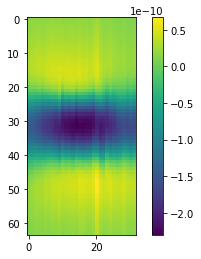

In [20]:
plt.imshow(newz)  
plt.colorbar()
plt.savefig('newz.png')

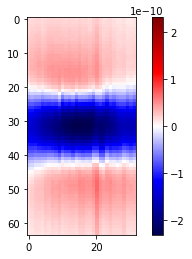

In [21]:
imshow_center(newz)  
plt.savefig('newz.png')

In [22]:
idx=np.nonzero(cscale>=0.009)
idx

(array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
        24, 25, 26, 27, 28, 29, 30, 31]),)

In [23]:
# this throws an error, what am I trying to do exactly?
if (fname=='fmap_2540'):
    idx=np.nonzero(cscale>=0.009);
    newy=newy[:,idx[0]];
    newz=newz[:,idx[0]];
    cscale=cscale[idx[0]];

In [24]:
print(newy.shape)
print(newz.shape)

(64, 32)
(64, 32)


### predict with simple model

In [25]:
def custom_loss_rmse(y_true,y_pred):
    loss=K.sqrt(K.mean(K.square(y_pred-y_true),axis=None))  #+K.sum(0*K.abs(penalty)) #can adjust the penalty weight
    return loss

In [26]:
model_ht2b=tf.keras.models.load_model('/content/drive/My Drive/Jerschow_Research/my_inversion/preprocess_suscept_inversion_files/model.best.h5',
                                      custom_objects={'custom_loss_rmse': custom_loss_rmse})

In [27]:
print(newy.shape)
print(newz.shape)

(64, 32)
(64, 32)


In [28]:
X_test_og = np.stack([newy, newz], axis=2)

assert np.all(X_test_og[:,:,0] == newy)
assert np.all(X_test_og[:,:,1] == newz)

In [29]:
X_test_og.shape

(64, 32, 2)

In [30]:
print(np.sqrt(np.mean(np.square(X_test_og))))

6.313796725383089e-11


In [31]:
# rescale to shift all values to be around 0~1 b/c that is what the model was trained to recognize
X_test = X_test_og * 1e10
  # only 1e10 or 1e11 works! 1e12 breaks it!

(1, 64, 32, 2)
(1, 32, 16, 3)


Text(0.5, 1.0, 'predicted z-suscept')

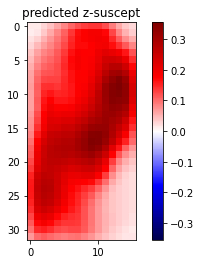

In [32]:
X_test = X_test[np.newaxis,:,:,:]
print(X_test.shape)
y_pred_ht2 = model_ht2b.predict(X_test)
print(y_pred_ht2.shape)

plt.figure()
imshow_center(y_pred_ht2[0,:,:,2])
plt.title("predicted z-suscept")

Text(0.5, 1.0, 'predicted y_suscept')

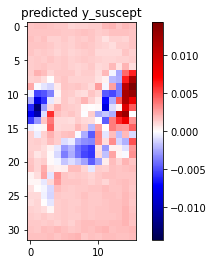

In [33]:
plt.figure()
imshow_center(y_pred_ht2[0,:,:,0])
plt.title("predicted y_suscept")
  # should be close to all zeros

Text(0.5, 1.0, 'predicted susceptibility')

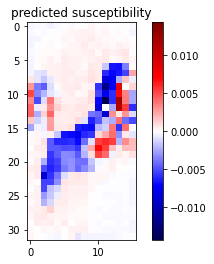

In [34]:
plt.figure()
imshow_center(y_pred_ht2[0,:,:,1])
plt.title("predicted susceptibility")
  # should be close to all zeros

Text(0.5, 1.0, 'y_field')

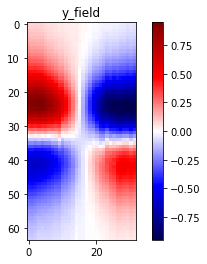

In [35]:
plt.figure()
imshow_center(X_test[0,:,:,0])
plt.title("y_field")

Text(0.5, 1.0, 'z_field')

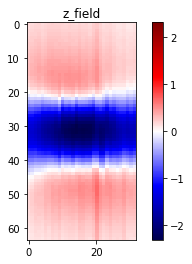

In [36]:
plt.figure()
imshow_center(X_test[0,:,:,1])
plt.title("z_field")

## predict on all experimental samples

In [37]:
fpath = '/content/drive/My Drive/Jerschow_Research/experimental data'

local_fpath='battdata-summary, new send May 2019';
# 2540: -87
# 2810: -117 
# 3000: -146
# 3100: -195
# 3340: -217
fname_list = []
# fname_list.append('fmap_2540')
fname_list.append('fmap_2810')
fname_list.append('fmap_3000')
fname_list.append('fmap_3100')
fname_list.append('fmap_3340')

In [38]:
expe_input_arr = np.empty((len(fname_list),64,32,2))
i=0

for fname in fname_list:
  print(fname)
  compfname = fpath + '/' + local_fpath + '/' + fname
  mat_contents = loadmat(compfname)
  cscale=mat_contents['cscale']
  rscale=mat_contents['rscale']
  zfield=mat_contents['zfield']
  yfield=mat_contents['yfield']

  # downsample/resample to match nn needs (seems like easiest is to stick to powers of two)
  df=10;
  newcscale=np.linspace(cscale.min(),cscale.max(),32)
  newrscale=np.linspace(rscale.min(),rscale.max(),64)

  yqfun = interpolate.interp2d(cscale,rscale,yfield)
  newy=yqfun(newcscale,newrscale)
  zqfun = interpolate.interp2d(cscale,rscale,zfield)
  newz=zqfun(newcscale,newrscale)

  rscale=newrscale
  cscale=newcscale

  newy=newy*1e-12;
  newz=newz*1e-12;

  print(newy.shape)
  print(newz.shape)

  if (fname=='fmap_2540'):
    print(len(newy))
    print(idx[0][1])
    idx=np.nonzero(cscale>=0.009);
    newy=newy[:,idx[0][1]];
    newz=newz[:,idx[0][1]];
    cscale=cscale[0:idx[0][1]];

  X_test = np.stack([newy, newz], axis=2)
  print(np.sqrt(np.mean(np.square(X_test))))
  X_test = X_test * 1e10
    # rescale by e10 to get the rms-mean closer to the synthetic data the model trained on
  print(np.sqrt(np.mean(np.square(X_test))))

  expe_input_arr[i,:,:,:] = X_test
  i = i+1
  print(50*'*')

fmap_2810
(64, 32)
(64, 32)
2.969017416144135e-11
0.2969017416144135
**************************************************
fmap_3000
(64, 32)
(64, 32)
4.097729687388197e-11
0.4097729687388197
**************************************************
fmap_3100
(64, 32)
(64, 32)
5.459113570408479e-11
0.5459113570408479
**************************************************
fmap_3340
(64, 32)
(64, 32)
6.313796725383089e-11
0.631379672538309
**************************************************


In [39]:
expe_input_arr.shape

(4, 64, 32, 2)

In [40]:
expe_input = tf.constant(expe_input_arr)
type(expe_input)

tensorflow.python.framework.ops.EagerTensor

In [41]:
def custom_loss_rmse(y_true,y_pred):
    loss=K.sqrt(K.mean(K.square(y_pred-y_true),axis=None))  #+K.sum(0*K.abs(penalty)) #can adjust the penalty weight
    return loss

In [42]:
n_list = [0, 0.01, 0.03, 0.05,
          0.07, 0.1, 0.2, 0.4, 
          0.6, 0.8, 1]

test_boll_rmse_lst = [0.33758558338378714, 0.3582208999639208, 0.37393770020951206, 0.3480783758425738,
                      0.38626023347215954, 0.3876631419674309, 0.3902154846462532, 0.42596870346660975, 
                      0.4688011961550924, 0.4971008470500618, 0.5299878001884477]

Text(0, 0.5, 'boll_RMSE on the syn test sets')

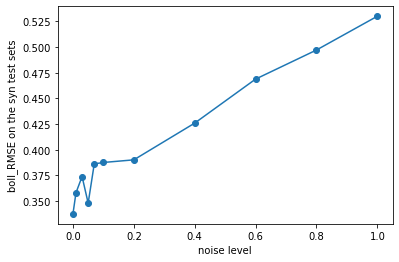

In [43]:
plt.plot(n_list, test_boll_rmse_lst, marker='o')
plt.xlabel('noise level')
plt.ylabel('boll_RMSE on the syn test sets')

In [44]:
folder_path = '/content/drive/My Drive/Jerschow_Research/experimental data/big_models'

### no noise big model

In [45]:
noise=0
file_path = folder_path+'/'+str(noise)+'.model.best.h5'
model_ht2b = tf.keras.models.load_model(file_path,custom_objects={'custom_loss_rmse': custom_loss_rmse})
print(file_path)

/content/drive/My Drive/Jerschow_Research/experimental data/big_models/0.model.best.h5


(4, 64, 32, 2)
(4, 32, 16, 3)
(4,)


Text(0.5, 0.6, 'predicted z-suscept')

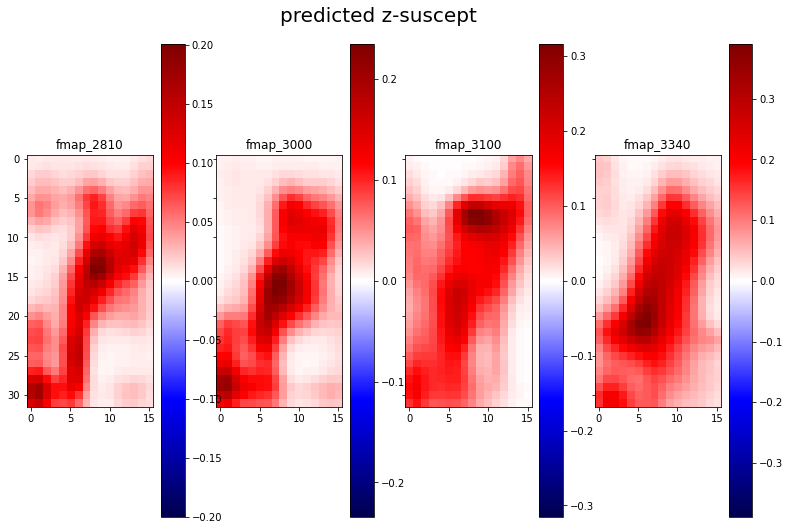

In [46]:
X_test = expe_input
print(X_test.shape)
y_pred_ht2 = model_ht2b.predict(X_test)
print(y_pred_ht2.shape)

fig,axs = plt.subplots(1,len(fname_list), sharey='row', figsize=(13,39))
print(axs.shape)

for i in range(len(fname_list)):
  plt.sca(axs[i])
  imshow_center(y_pred_ht2[i,:,:,2])
  plt.title(str(fname_list[i]))
  # plt.figure()
  # imshow_center(y_pred_ht2[i,:,:,1])
  # plt.title("predicted y_suscept for "+str(fname_list[i]))
  # plt.figure()
  # imshow_center(y_pred_ht2[i,:,:,0])
  # plt.title("predicted x_suscept for "+str(fname_list[i]))

fig.suptitle("predicted z-suscept", fontsize=20, y=0.6)
# fig.subplots_adjust(top=-20)

### 0.01 noise big model

In [47]:
noise=0.01
file_path = folder_path+'/'+str(noise)+'.model.best.h5'
model_ht2b = tf.keras.models.load_model(file_path,custom_objects={'custom_loss_rmse': custom_loss_rmse})
print(file_path)

/content/drive/My Drive/Jerschow_Research/experimental data/big_models/0.01.model.best.h5


(4, 64, 32, 2)
(4, 32, 16, 3)
(4,)


Text(0.5, 0.6, 'predicted z-suscept')

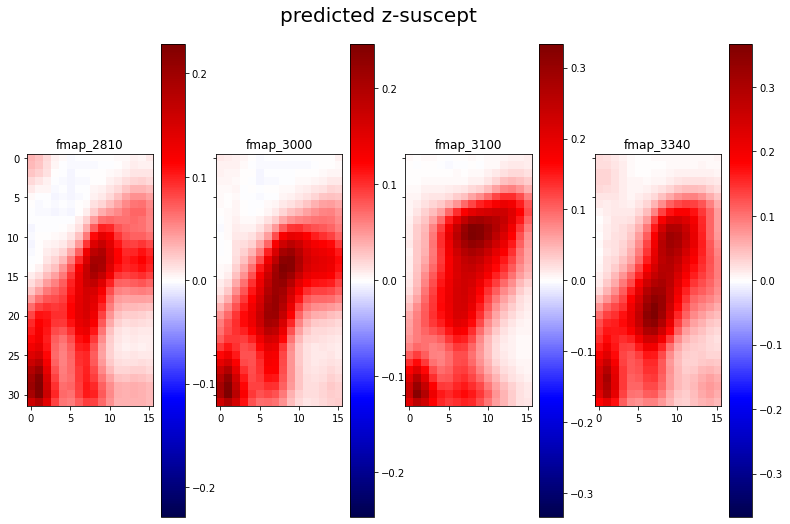

In [48]:
X_test = expe_input
print(X_test.shape)
y_pred_ht2 = model_ht2b.predict(X_test)
print(y_pred_ht2.shape)

fig,axs = plt.subplots(1,len(fname_list), sharey='row', figsize=(13,39))
print(axs.shape)

for i in range(len(fname_list)):
  plt.sca(axs[i])
  imshow_center(y_pred_ht2[i,:,:,2])
  plt.title(str(fname_list[i]))
  # plt.figure()
  # imshow_center(y_pred_ht2[i,:,:,1])
  # plt.title("predicted y_suscept for "+str(fname_list[i]))
  # plt.figure()
  # imshow_center(y_pred_ht2[i,:,:,0])
  # plt.title("predicted x_suscept for "+str(fname_list[i]))

fig.suptitle("predicted z-suscept", fontsize=20, y=0.6)
# fig.subplots_adjust(top=-20)

### 0.03 noise big model

In [49]:
noise=0.03
file_path = folder_path+'/'+str(noise)+'.model.best.h5'
model_ht2b = tf.keras.models.load_model(file_path,custom_objects={'custom_loss_rmse': custom_loss_rmse})
print(file_path)

/content/drive/My Drive/Jerschow_Research/experimental data/big_models/0.03.model.best.h5


(4, 64, 32, 2)
(4, 32, 16, 3)
(4,)


Text(0.5, 0.6, 'predicted z-suscept')

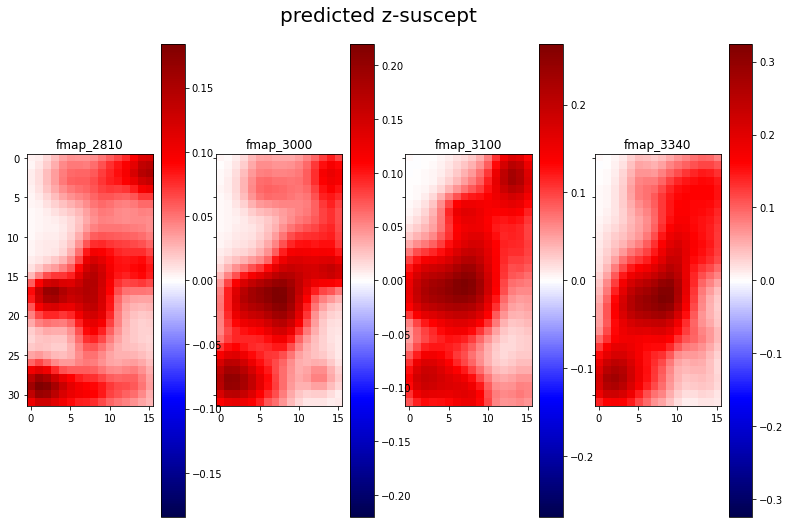

In [50]:
X_test = expe_input
print(X_test.shape)
y_pred_ht2 = model_ht2b.predict(X_test)
print(y_pred_ht2.shape)

fig,axs = plt.subplots(1,len(fname_list), sharey='row', figsize=(13,39))
print(axs.shape)

for i in range(len(fname_list)):
  plt.sca(axs[i])
  imshow_center(y_pred_ht2[i,:,:,2])
  plt.title(str(fname_list[i]))
  # plt.figure()
  # imshow_center(y_pred_ht2[i,:,:,1])
  # plt.title("predicted y_suscept for "+str(fname_list[i]))
  # plt.figure()
  # imshow_center(y_pred_ht2[i,:,:,0])
  # plt.title("predicted x_suscept for "+str(fname_list[i]))

fig.suptitle("predicted z-suscept", fontsize=20, y=0.6)
# fig.subplots_adjust(top=-20)

### 0.05 noise big model

In [51]:
noise=0.05
file_path = folder_path+'/'+str(noise)+'.model.best.h5'
model_ht2b = tf.keras.models.load_model(file_path,custom_objects={'custom_loss_rmse': custom_loss_rmse})
print(file_path)

/content/drive/My Drive/Jerschow_Research/experimental data/big_models/0.05.model.best.h5


(4, 64, 32, 2)
(4, 32, 16, 3)
(4,)


Text(0.5, 0.6, 'predicted z-suscept')

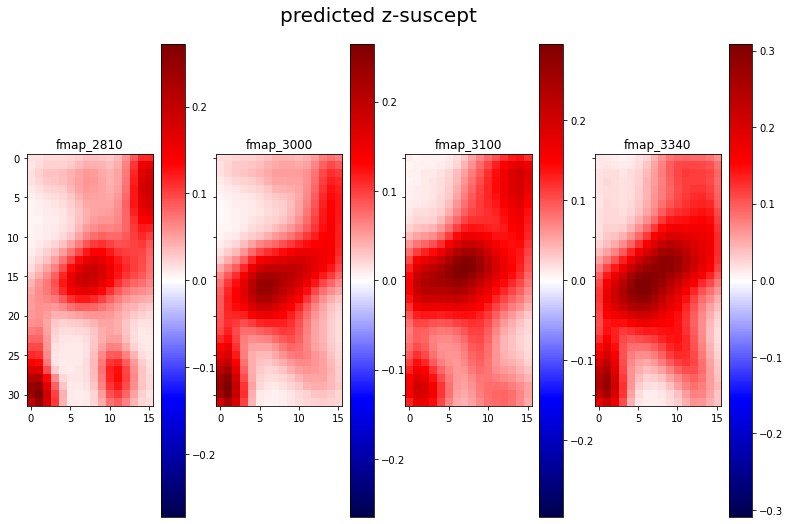

In [52]:
X_test = expe_input
print(X_test.shape)
y_pred_ht2 = model_ht2b.predict(X_test)
print(y_pred_ht2.shape)

fig,axs = plt.subplots(1,len(fname_list), sharey='row', figsize=(13,39))
print(axs.shape)

for i in range(len(fname_list)):
  plt.sca(axs[i])
  imshow_center(y_pred_ht2[i,:,:,2])
  plt.title(str(fname_list[i]))
  # plt.figure()
  # imshow_center(y_pred_ht2[i,:,:,1])
  # plt.title("predicted y_suscept for "+str(fname_list[i]))
  # plt.figure()
  # imshow_center(y_pred_ht2[i,:,:,0])
  # plt.title("predicted x_suscept for "+str(fname_list[i]))

fig.suptitle("predicted z-suscept", fontsize=20, y=0.6)
# fig.subplots_adjust(top=-20)

### 0.07 noise big model

In [53]:
noise=0.07
file_path = folder_path+'/'+str(noise)+'.model.best.h5'
model_ht2b = tf.keras.models.load_model(file_path,custom_objects={'custom_loss_rmse': custom_loss_rmse})
print(file_path)

/content/drive/My Drive/Jerschow_Research/experimental data/big_models/0.07.model.best.h5


(4, 64, 32, 2)
(4, 32, 16, 3)
(4,)


Text(0.5, 0.6, 'predicted z-suscept')

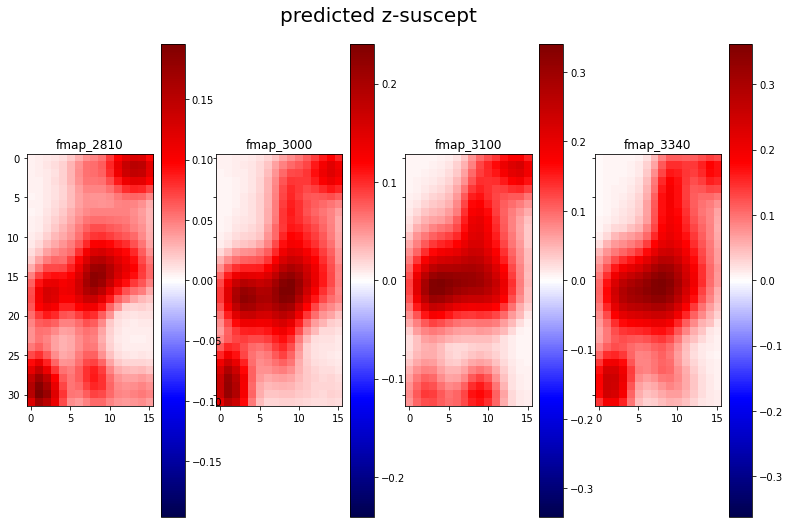

In [54]:
X_test = expe_input
print(X_test.shape)
y_pred_ht2 = model_ht2b.predict(X_test)
print(y_pred_ht2.shape)

fig,axs = plt.subplots(1,len(fname_list), sharey='row', figsize=(13,39))
print(axs.shape)

for i in range(len(fname_list)):
  plt.sca(axs[i])
  imshow_center(y_pred_ht2[i,:,:,2])
  plt.title(str(fname_list[i]))
  # plt.figure()
  # imshow_center(y_pred_ht2[i,:,:,1])
  # plt.title("predicted y_suscept for "+str(fname_list[i]))
  # plt.figure()
  # imshow_center(y_pred_ht2[i,:,:,0])
  # plt.title("predicted x_suscept for "+str(fname_list[i]))

fig.suptitle("predicted z-suscept", fontsize=20, y=0.6)
# fig.subplots_adjust(top=-20)

### 0.1 noise big model

In [55]:
noise=0.1
file_path = folder_path+'/'+str(noise)+'.model.best.h5'
model_ht2b = tf.keras.models.load_model(file_path,custom_objects={'custom_loss_rmse': custom_loss_rmse})
print(file_path)

/content/drive/My Drive/Jerschow_Research/experimental data/big_models/0.1.model.best.h5


(4, 64, 32, 2)
(4, 32, 16, 3)
(4,)


Text(0.5, 0.6, 'predicted z-suscept')

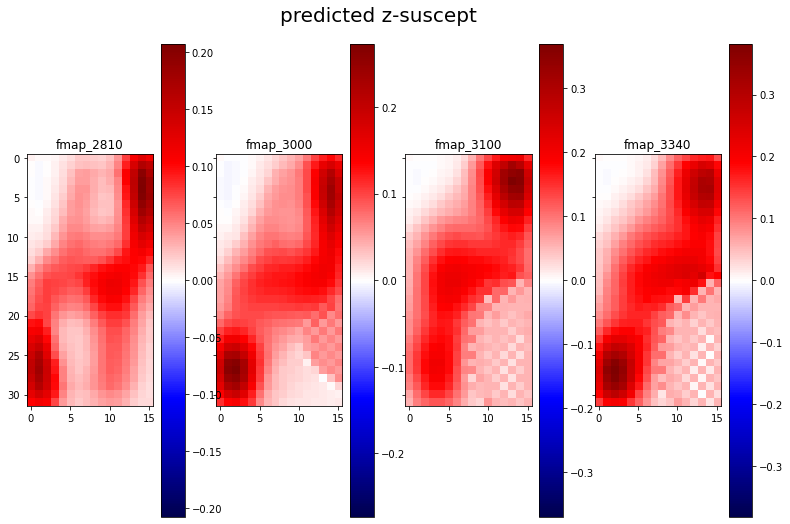

In [56]:
X_test = expe_input
print(X_test.shape)
y_pred_ht2 = model_ht2b.predict(X_test)
print(y_pred_ht2.shape)

fig,axs = plt.subplots(1,len(fname_list), sharey='row', figsize=(13,39))
print(axs.shape)

for i in range(len(fname_list)):
  plt.sca(axs[i])
  imshow_center(y_pred_ht2[i,:,:,2])
  plt.title(str(fname_list[i]))
  # plt.figure()
  # imshow_center(y_pred_ht2[i,:,:,1])
  # plt.title("predicted y_suscept for "+str(fname_list[i]))
  # plt.figure()
  # imshow_center(y_pred_ht2[i,:,:,0])
  # plt.title("predicted x_suscept for "+str(fname_list[i]))

fig.suptitle("predicted z-suscept", fontsize=20, y=0.6)
# fig.subplots_adjust(top=-20)

### 0.2 noise big model

In [57]:
noise=0.2
file_path = folder_path+'/'+str(noise)+'.model.best.h5'
model_ht2b = tf.keras.models.load_model(file_path,custom_objects={'custom_loss_rmse': custom_loss_rmse})
print(file_path)

/content/drive/My Drive/Jerschow_Research/experimental data/big_models/0.2.model.best.h5


(4, 64, 32, 2)
(4, 32, 16, 3)
(4,)


Text(0.5, 0.6, 'predicted z-suscept')

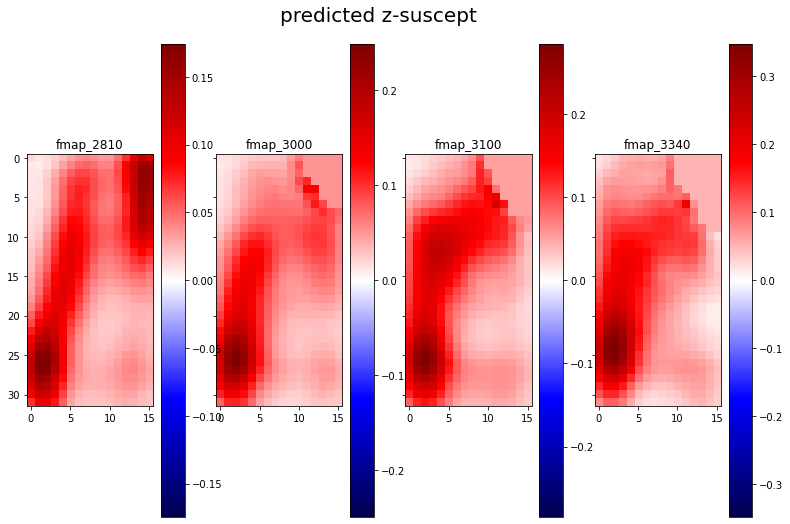

In [58]:
X_test = expe_input
print(X_test.shape)
y_pred_ht2 = model_ht2b.predict(X_test)
print(y_pred_ht2.shape)

fig,axs = plt.subplots(1,len(fname_list), sharey='row', figsize=(13,39))
print(axs.shape)

for i in range(len(fname_list)):
  plt.sca(axs[i])
  imshow_center(y_pred_ht2[i,:,:,2])
  plt.title(str(fname_list[i]))
  # plt.figure()
  # imshow_center(y_pred_ht2[i,:,:,1])
  # plt.title("predicted y_suscept for "+str(fname_list[i]))
  # plt.figure()
  # imshow_center(y_pred_ht2[i,:,:,0])
  # plt.title("predicted x_suscept for "+str(fname_list[i]))

fig.suptitle("predicted z-suscept", fontsize=20, y=0.6)
# fig.subplots_adjust(top=-20)

### 0.4 noise big model

In [59]:
noise=0.4
file_path = folder_path+'/'+str(noise)+'.model.best.h5'
model_ht2b = tf.keras.models.load_model(file_path,custom_objects={'custom_loss_rmse': custom_loss_rmse})
print(file_path)

/content/drive/My Drive/Jerschow_Research/experimental data/big_models/0.4.model.best.h5


(4, 64, 32, 2)
(4, 32, 16, 3)
(4,)


Text(0.5, 0.6, 'predicted z-suscept')

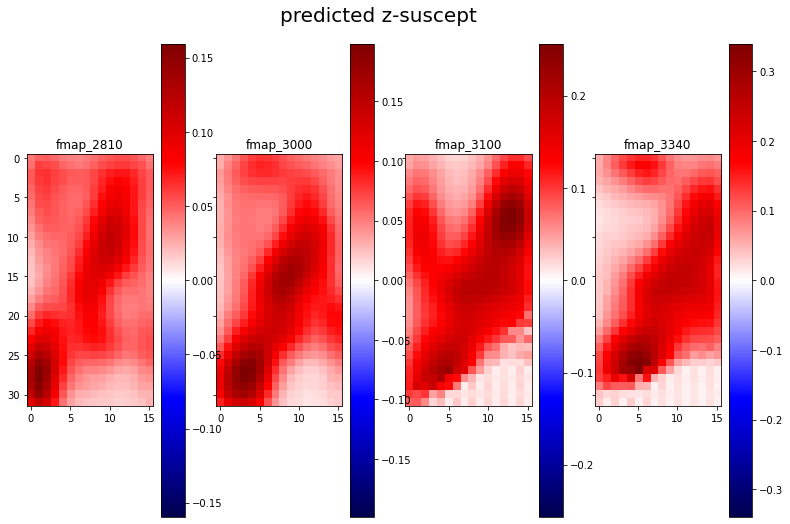

In [60]:
X_test = expe_input
print(X_test.shape)
y_pred_ht2 = model_ht2b.predict(X_test)
print(y_pred_ht2.shape)

fig,axs = plt.subplots(1,len(fname_list), sharey='row', figsize=(13,39))
print(axs.shape)

for i in range(len(fname_list)):
  plt.sca(axs[i])
  imshow_center(y_pred_ht2[i,:,:,2])
  plt.title(str(fname_list[i]))
  # plt.figure()
  # imshow_center(y_pred_ht2[i,:,:,1])
  # plt.title("predicted y_suscept for "+str(fname_list[i]))
  # plt.figure()
  # imshow_center(y_pred_ht2[i,:,:,0])
  # plt.title("predicted x_suscept for "+str(fname_list[i]))

fig.suptitle("predicted z-suscept", fontsize=20, y=0.6)
# fig.subplots_adjust(top=-20)

### 0.6 noise big model

In [61]:
noise=0.6
file_path = folder_path+'/'+str(noise)+'.model.best.h5'
model_ht2b = tf.keras.models.load_model(file_path,custom_objects={'custom_loss_rmse': custom_loss_rmse})
print(file_path)

/content/drive/My Drive/Jerschow_Research/experimental data/big_models/0.6.model.best.h5


(4, 64, 32, 2)
(4, 32, 16, 3)
(4,)


Text(0.5, 0.6, 'predicted z-suscept')

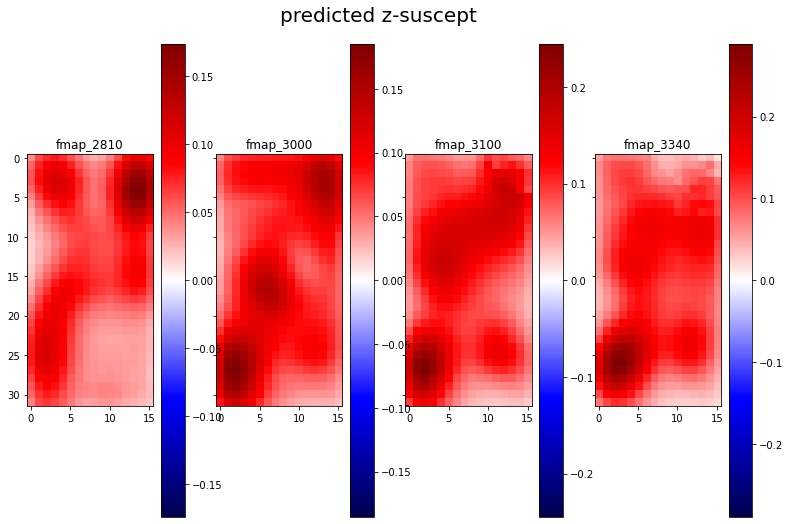

In [62]:
X_test = expe_input
print(X_test.shape)
y_pred_ht2 = model_ht2b.predict(X_test)
print(y_pred_ht2.shape)

fig,axs = plt.subplots(1,len(fname_list), sharey='row', figsize=(13,39))
print(axs.shape)

for i in range(len(fname_list)):
  plt.sca(axs[i])
  imshow_center(y_pred_ht2[i,:,:,2])
  plt.title(str(fname_list[i]))
  # plt.figure()
  # imshow_center(y_pred_ht2[i,:,:,1])
  # plt.title("predicted y_suscept for "+str(fname_list[i]))
  # plt.figure()
  # imshow_center(y_pred_ht2[i,:,:,0])
  # plt.title("predicted x_suscept for "+str(fname_list[i]))

fig.suptitle("predicted z-suscept", fontsize=20, y=0.6)
# fig.subplots_adjust(top=-20)

### 0.8 noise big model

In [63]:
noise=0.8
file_path = folder_path+'/'+str(noise)+'.model.best.h5'
model_ht2b = tf.keras.models.load_model(file_path,custom_objects={'custom_loss_rmse': custom_loss_rmse})
print(file_path)

/content/drive/My Drive/Jerschow_Research/experimental data/big_models/0.8.model.best.h5


(4, 64, 32, 2)
(4, 32, 16, 3)
(4,)


Text(0.5, 0.6, 'predicted z-suscept')

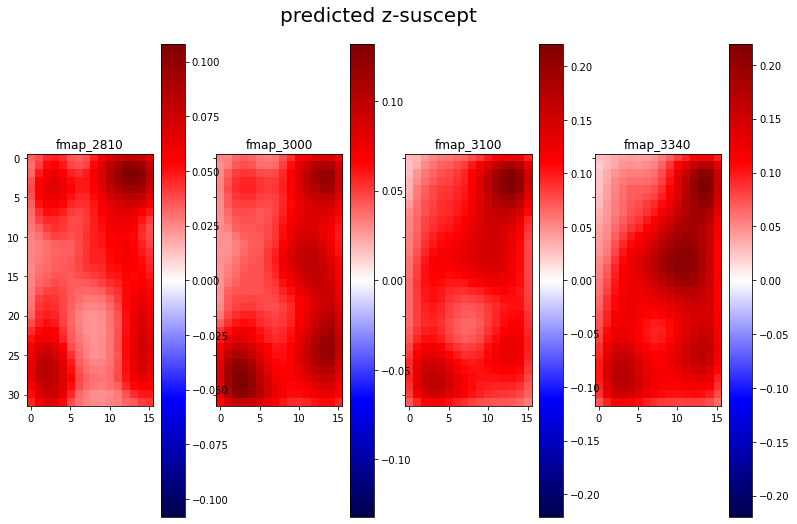

In [64]:
X_test = expe_input
print(X_test.shape)
y_pred_ht2 = model_ht2b.predict(X_test)
print(y_pred_ht2.shape)

fig,axs = plt.subplots(1,len(fname_list), sharey='row', figsize=(13,39))
print(axs.shape)

for i in range(len(fname_list)):
  plt.sca(axs[i])
  imshow_center(y_pred_ht2[i,:,:,2])
  plt.title(str(fname_list[i]))
  # plt.figure()
  # imshow_center(y_pred_ht2[i,:,:,1])
  # plt.title("predicted y_suscept for "+str(fname_list[i]))
  # plt.figure()
  # imshow_center(y_pred_ht2[i,:,:,0])
  # plt.title("predicted x_suscept for "+str(fname_list[i]))

fig.suptitle("predicted z-suscept", fontsize=20, y=0.6)
# fig.subplots_adjust(top=-20)

### 1 noise big model

In [65]:
noise=1
file_path = folder_path+'/'+str(noise)+'.model.best.h5'
model_ht2b = tf.keras.models.load_model(file_path,custom_objects={'custom_loss_rmse': custom_loss_rmse})
print(file_path)

/content/drive/My Drive/Jerschow_Research/experimental data/big_models/1.model.best.h5


(4, 64, 32, 2)
(4, 32, 16, 3)
(4,)


Text(0.5, 0.6, 'predicted z-suscept')

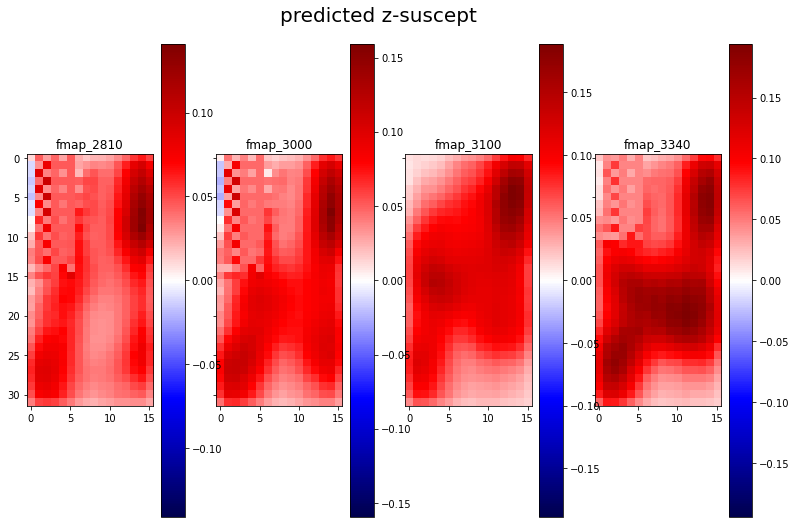

In [66]:
X_test = expe_input
print(X_test.shape)
y_pred_ht2 = model_ht2b.predict(X_test)
print(y_pred_ht2.shape)

fig,axs = plt.subplots(1,len(fname_list), sharey='row', figsize=(13,39))
print(axs.shape)

for i in range(len(fname_list)):
  plt.sca(axs[i])
  imshow_center(y_pred_ht2[i,:,:,2])
  plt.title(str(fname_list[i]))
  # plt.figure()
  # imshow_center(y_pred_ht2[i,:,:,1])
  # plt.title("predicted y_suscept for "+str(fname_list[i]))
  # plt.figure()
  # imshow_center(y_pred_ht2[i,:,:,0])
  # plt.title("predicted x_suscept for "+str(fname_list[i]))

fig.suptitle("predicted z-suscept", fontsize=20, y=0.6)
# fig.subplots_adjust(top=-20)

## SVD - setup

In [67]:
battery_dims=np.array([5,30,40])*1e-3;
dims=np.array([5,50,60])*1e-3;  # cell dimensions

In [68]:
probe_dist=1.59e-2;   # 2 cm top and bottom
npts=[1,16,32];
dV=np.prod(dims/npts);   # this is volume per point in the susceptibility map, seems the correct way

# for new send data
centery=0.021;
centerz=0.062;

field_dims=np.array([60,80])*1e-3;
# see here: this volume probably calculated incorrectly, but it's also probably not needed
field_npts=[20,30];
dVfield=np.prod(field_dims/field_npts);  

In [69]:
# this way bottom of cell starts at x=0 (+padding), so the probe_dist is measured from the bottom of cell
srcpos=[[],[],[]]
for i in range(3):
    srcpos[i]=np.linspace(0,dims[i],npts[i]+2)
    srcpos[i]=srcpos[i][1:(npts[i]+1)]
srcpos[1]=srcpos[1]+centery-dims[1]/2
srcpos[2]=srcpos[2]+centerz-dims[2]/2

srcxv,srcyv,srczv=np.meshgrid(srcpos[0],srcpos[1],srcpos[2],indexing='ij')

src_fulllength=np.prod(npts)
src_pos_list=np.concatenate((srcxv.reshape((src_fulllength,1)),
                             srcyv.reshape((src_fulllength,1)),
                             srczv.reshape((src_fulllength,1))),axis=1)

In [70]:
rv, cv = np.meshgrid(rscale, cscale, indexing='ij')  # ij indexing produces same shape as newy, newz
fulllength=np.prod(newy.shape)
print(fulllength)

2048


In [71]:
field_pos_list=np.concatenate((cv.reshape((fulllength,1)),rv.reshape((fulllength,1))),axis=1)
field_pos_list=np.insert(field_pos_list,0,probe_dist,axis=1)
print(field_pos_list.shape)

(2048, 3)


### 1-D

In [79]:
# modified for multidim to include multiple field components (y-z)
# now modif for x-y-z source dims

oneD=True   
  # whether or not to do z-only calc in this framework

# make sure to reshape such that multiply the correct field components
# A matrix is not very sparse, so maybe faster to do in non-sparse setup
fpl=field_pos_list.shape[0]
  # total number of field grid points per 1 channel of the field image
spl=src_pos_list.shape[0]
  # total number of suscept grid points per 1 channel of the suscept image

A=np.zeros((2,fpl,spl,3),dtype=float)
  # allocate space for the coefficient matrix
  # need to account for all 2 channels of the field and all 3 channels of the suscept

for i in range(src_pos_list.shape[0]):
    posdiff=src_pos_list[i,:]-field_pos_list
    inv_r=1/np.sqrt(np.sum(posdiff**2,axis=1))
    inv_r5=inv_r**5
    inv_r3=inv_r**3
    
    for fidx in range(2):
        fidx2=fidx+1    # this is the real dim index (compatible with sidx)
                        # since I only have y and z components of the field
                        # they corresponds to the [1] and [2] indices of each grid position
        
        if oneD:  
          # then we only fill in the last dimension for the suscept, aka, the [2] index
          # keep all other coefficients 0
          sidx=2
          A[fidx,:,i,sidx]=3*posdiff[:,fidx2]*posdiff[:,sidx]*inv_r5
          if sidx==fidx2:
            A[fidx,:,i,sidx]=A[fidx,:,i,sidx]-inv_r3
        
        else:     
          # then we fill in all 3 dimensions for the suscept
          for sidx in range(3):
            A[fidx,:,i,sidx]=3*posdiff[:,fidx2]*posdiff[:,sidx]*inv_r5
            if sidx==fidx2:
              A[fidx,:,i,sidx]=A[fidx,:,i,sidx]-inv_r3
    
A=A.reshape((fpl*2,src_pos_list.shape[0]*3))
  # 2-D matrix with dim: 64*32*2-by-32*16*3
  # so each row multiplies all field values of 1 battery sample

* the important thing is to figure out how it is reshaped. 
* before, A had shape (2, 2048, 512, 3)
* allocate a new 2-D array with shape (4096, 1536)

each row is filled in first with 
1. `newA[0,0] = oldA[0,0,0,0]`
1. `newA[0,1] = oldA[0,0,0,1]`
1. `newA[0,3] = oldA[0,0,0,2]`
1. `newA[0,4] = oldA[0,0,1,0]`
1. `newA[0,5] = oldA[0,0,1,1]`
1. `newA[0,6] = oldA[0,0,1,2]`
1. ...


So each row of the `A` matrix is filled with coefficients in the order of `x,y,z,x,y,z,...`. Thus, When we multiply the `A` matrix with the the `mag-suscept`, the `mag-suscept` needs to be reshaped into a column vector also of the save order `x,y,z,x,y,z,...`. This is why in the `calcfield` function, the `A` matrix is multiplied with the reshaped suscept image, because that `np.reshape` will by default unpack values in the same order.

However, for the inverse multiplication, since the `2` of the old shape `(2, 2048, 512, 3)` was the last dimension unpacked during reshaping `A`, each **column** of the the `A` matrix were filled with all `y-field` coefficients first, and then all `z-field` coefficients next. It was not intertwined like the coefficients for the susceptibilities. thus, when we use the inverse matrix `P` (which was calculated from `A`) to multiply our `mag-field` image, we need to reshape the `fields` into all `y-channel` in the first half, and then all `z-channel` in the second half. That is why we can no longer just simply use the `np.reshape` method, but instead needs to concatenate the two flattened `field` arrays. 

(then, maybe look into the `calcfield` function where after multiplying the correct components with each other, is it correct to lump the first entire half of the result as the `y-field` and the second entire half as the `z-field`? Should the `y` and `z` field components be separated out in a skipping manner?)

In [80]:
B0=20e-6
A=A*dV*B0/4/np.pi

In [81]:
print(A.shape)

(4096, 1536)


#### method2: SVD approach using pinv ocmmand to calculate the pseudoinverse (much faster)

In [82]:
rcond=1e-1    # 1e-3 starts to significantly degrade synthetic data
P=np.linalg.pinv(A,rcond)

In [83]:
print(A.shape)
print(P.shape)

(4096, 1536)
(1536, 4096)


## Use SVD to calculate result (for now just using second approach)
* you could test, for example how well it performs with synthetic data based on what rcond value is, but for the experimental data it appeared to be a narrow range around 1e-1. Was not fully explored yet
* note that 

### one sample

In [91]:
print(A.shape)
print(P.shape)

(4096, 1536)
(1536, 4096)


In [84]:
# magfield was undefined in the code, is this the correct way?
# this is not the correct way
my_magfield = np.squeeze(expe_input_arr[-1]).reshape(fulllength*2)
my_magfield = my_magfield[:,np.newaxis]
print(my_magfield.shape)

(4096, 1)


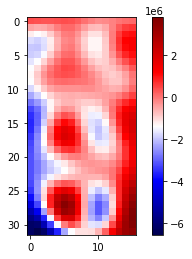

In [85]:
result=np.dot(P,my_magfield)
result=result.reshape((npts[0],npts[1],npts[2],3))
plt.imshow(np.transpose(np.squeeze(result[0,:,:,2])),cmap='seismic')
# transpose to have z point up
plt.colorbar()

In [86]:
# this is still not the correct way
# was only done to make sure error was not due to data storage
my_magfield2 = np.reshape(np.stack((newy, newz), axis=2), fulllength*2)
my_magfield2 = my_magfield2[:, np.newaxis]
print(my_magfield2.shape)

(4096, 1)


In [88]:
# Jerschow's way, which is the correct way of unpacking the field values
magfield=np.concatenate((newy.reshape((fulllength,1)),newz.reshape((fulllength,1))),axis=0)
print(magfield.shape)

(4096, 1)


In [90]:
my_magfield == magfield * 1e10

array([[ True],
       [False],
       [False],
       ...,
       [False],
       [False],
       [ True]])

In [91]:
my_magfield == my_magfield2 * 1e10

array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [ True],
       [ True]])

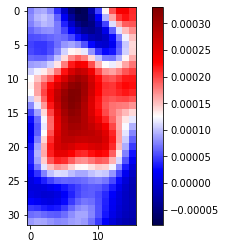

In [92]:
result=np.dot(P,magfield)
result=result.reshape((npts[0],npts[1],npts[2],3))
plt.imshow(np.transpose(np.squeeze(result[0,:,:,2])),cmap='seismic')
# transpose to have z point up
plt.colorbar()

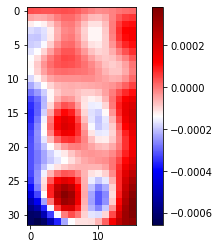

In [93]:
result=np.dot(P,my_magfield2)
result=result.reshape((npts[0],npts[1],npts[2],3))
plt.imshow(np.transpose(np.squeeze(result[0,:,:,2])),cmap='seismic')
# transpose to have z point up
plt.colorbar()

In [94]:
np.all(expe_input_arr[3,:,:,0] == newy * 1e10)

True

In [95]:
np.all(expe_input_arr[3,:,:,1] == newz * 1e10)

True

So the reason I am getting different calculations is not because numbers got changes when I put them all in the tensor, but it is because the reshaping action was different when trying to get them into the right shape for the matrix multiplication.

### reshaping test

In [102]:
yarr = 2 * np.ones((2,2))
zarr = np.zeros((2,2))

In [103]:
yarr

array([[2., 2.],
       [2., 2.]])

In [104]:
zarr

array([[0., 0.],
       [0., 0.]])

#### stack then reshape way

In [109]:
# my way
sample = np.stack((yarr, zarr), axis=2)
print(sample[:,:,0])
print()
print(sample[:,:,1])

[[2. 2.]
 [2. 2.]]

[[0. 0.]
 [0. 0.]]


In [106]:
sample_vec = sample.reshape(8)
sample_vec = sample_vec[:, np.newaxis]
sample_vec

array([[2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.]])

so the problem is when you use the `np.reshape` function, the default order is C-like, with the last axis index changing fastest, back to the first axis index changing slowest. This means that while you're filling in the new reshaped array with the same values from the old array, you are filling them in with the following order:

1. `arr[0,0,0] = 2`

1. `arr[0,0,1] = 0`

1. `arr[0,1,0] = 2`

1. `arr[0,1,1] = 0`

1. ...

So you are actually intertwinning the `y-field` values with the `z-field` values, instead of making all `y-field` values go in first, then the `z-field` values.

This intertwining of values of course can cause some confusion, but it is not necessarily wrong. Whether it produces the right matrix products fully depends on how the `A`, and in turn, the `P` matrix is set up. If those matrices were set up where the first half of each row is intended to be multiplied to the `y-chanel`, and the second half to the `z-chanel`, then this method of reshaping our input mag-field image is wrong. But if `A` and `P` were reshaped using the same `np.reshape` function, then more investigation is needed to make sure the right coefficients are matched to the right field values. 

In [107]:
sample_vec = sample.reshape(8, order='F')
sample_vec = sample_vec[:, np.newaxis]
sample_vec

array([[2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.]])

#### reshape then concatenate way

In [110]:
# magfield=np.concatenate((newy.reshape((fulllength,1)),newz.reshape((fulllength,1))),axis=0)
sample_vec = np.concatenate((yarr.reshape((4,1)), zarr.reshape((4,1))), axis=0)
sample_vec

array([[2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.]])

This way, each 2-D matrix was first reshaped into a column vector by flattening out each row, and then the 2 column vectors were concatenated, with the first half of the column vector being the first `y-channel` and the second half of the column vector being the second `z-channel`.

### all samples

In [96]:
print(fname_list)

['fmap_2810', 'fmap_3000', 'fmap_3100', 'fmap_3340']


In [99]:
b = 10
a = b*1e10
b == a*1e-10

True

(4,)
(1, 16, 32, 3)
(1, 16, 32, 3)
(1, 16, 32, 3)
(1, 16, 32, 3)


Text(0.5, 0.6, 'predicted z-suscept')

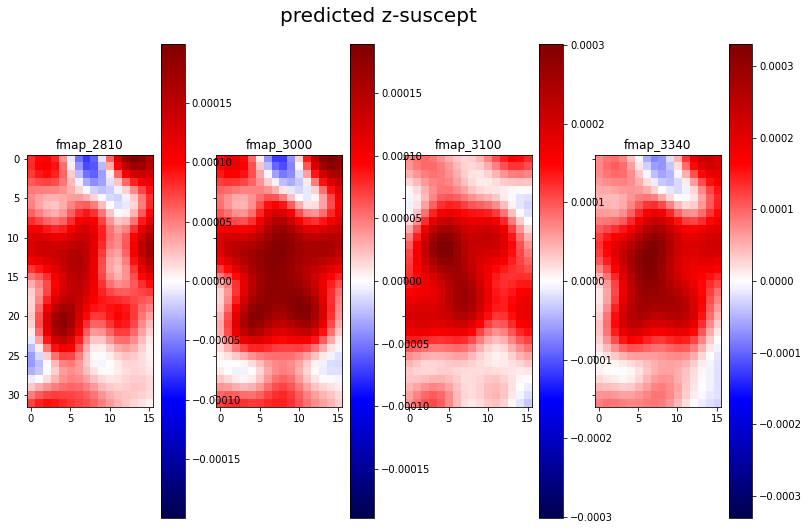

In [105]:
fig,axs = plt.subplots(1,len(fname_list), sharey='row', figsize=(13,39))
print(axs.shape)

for i in range(len(fname_list)):
  newy = expe_input_arr[i,:,:,0]*1e-10
  newz = expe_input_arr[i,:,:,1]*1e-10
    # scale back to original values
  magfield=np.concatenate((newy.reshape((fulllength,1)),newz.reshape((fulllength,1))),axis=0)
  result=np.dot(P,magfield)
  result=result.reshape((npts[0],npts[1],npts[2],3))
  print(result.shape)
  
  plt.sca(axs[i])
  imshow_center(np.transpose(result[0,:,:,2]))
  plt.title(str(fname_list[i]))
  # plt.figure()
  # imshow_center(y_pred_ht2[i,:,:,1])
  # plt.title("predicted y_suscept for "+str(fname_list[i]))
  # plt.figure()
  # imshow_center(y_pred_ht2[i,:,:,0])
  # plt.title("predicted x_suscept for "+str(fname_list[i]))

fig.suptitle("predicted z-suscept", fontsize=20, y=0.6)
# fig.subplots_adjust(top=-20)

In [101]:
np.any(expe_input_arr[0] == expe_input_arr[2])

False

(4,)
(32, 16, 3)
(32, 16, 3)
(32, 16, 3)
(32, 16, 3)


Text(0.5, 0.6, 'predicted z-suscept')

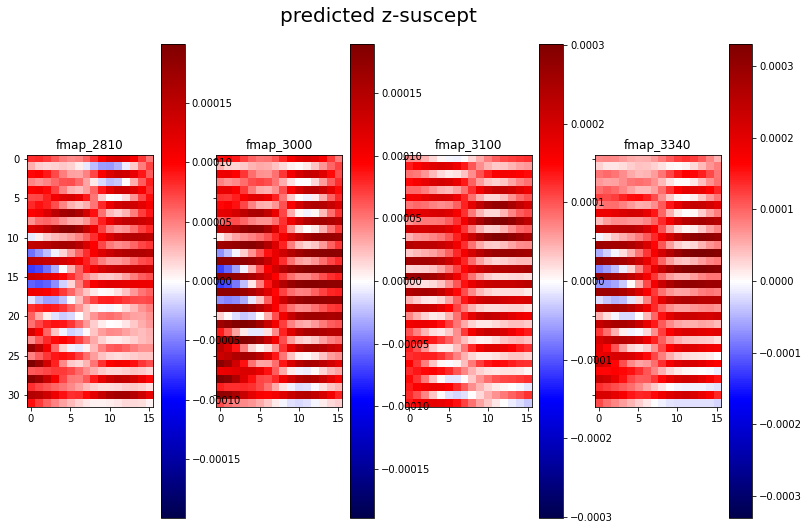

In [104]:
fig,axs = plt.subplots(1,len(fname_list), sharey='row', figsize=(13,39))
print(axs.shape)

for i in range(len(fname_list)):
  newy = expe_input_arr[i,:,:,0]*1e-10
  newz = expe_input_arr[i,:,:,1]*1e-10
    # scale back to original values
  magfield=np.concatenate((newy.reshape((fulllength,1)),newz.reshape((fulllength,1))),axis=0)
  result=np.dot(P,magfield)
  result=result.reshape((npts[2],npts[1],3))
  print(result.shape)
  
  plt.sca(axs[i])
  imshow_center((result[:,:,2]))
  plt.title(str(fname_list[i]))
  # plt.figure()
  # imshow_center(y_pred_ht2[i,:,:,1])
  # plt.title("predicted y_suscept for "+str(fname_list[i]))
  # plt.figure()
  # imshow_center(y_pred_ht2[i,:,:,0])
  # plt.title("predicted x_suscept for "+str(fname_list[i]))

fig.suptitle("predicted z-suscept", fontsize=20, y=0.6)
# fig.subplots_adjust(top=-20)

In [112]:
# we cannot just simply reshape the result image into the correct dimensions
# the result was calculated for the transpose image, so we need to first reshape it into the transpose
# then, transpose the transpose to store the correct orientation of the graph into the prediction tensor

(4,)
(1, 16, 32, 3)
(1, 32, 16, 3)
(1, 16, 32, 3)
(1, 32, 16, 3)
(1, 16, 32, 3)
(1, 32, 16, 3)
(1, 16, 32, 3)
(1, 32, 16, 3)


Text(0.5, 0.6, 'predicted z-suscept')

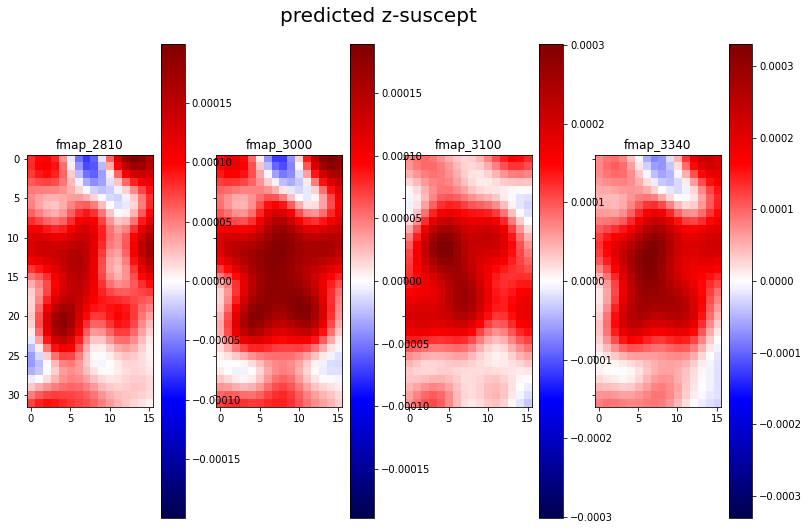

In [111]:
fig,axs = plt.subplots(1,len(fname_list), sharey='row', figsize=(13,39))
print(axs.shape)

for i in range(len(fname_list)):
  newy = expe_input_arr[i,:,:,0]*1e-10
  newz = expe_input_arr[i,:,:,1]*1e-10
    # scale back to original values
  magfield=np.concatenate((newy.reshape((fulllength,1)),newz.reshape((fulllength,1))),axis=0)
  result=np.dot(P,magfield)
  result=result.reshape((npts[0],npts[1],npts[2],3))
  print(result.shape)
  y_pred_svd = np.empty((1,32,16,3))
  for ii in range(3):
    y_pred_svd[0,:,:,ii] = np.squeeze(np.transpose(result[:,:,:,ii]))
  print(y_pred_svd.shape)
  
  plt.sca(axs[i])
  imshow_center((y_pred_svd[0,:,:,2]))
  plt.title(str(fname_list[i]))
  # plt.figure()
  # imshow_center(y_pred_ht2[i,:,:,1])
  # plt.title("predicted y_suscept for "+str(fname_list[i]))
  # plt.figure()
  # imshow_center(y_pred_ht2[i,:,:,0])
  # plt.title("predicted x_suscept for "+str(fname_list[i]))

fig.suptitle("predicted z-suscept", fontsize=20, y=0.6)
# fig.subplots_adjust(top=-20)